Carga del dataset y división inicial en train/test

In [48]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer


import matplotlib.pyplot as plt
import seaborn as sns

ruta = "airbnb-listings-extract.csv"
df = pd.read_csv(ruta, sep=None, engine="python")
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)
train_df.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
4462,8494011,https://www.airbnb.com/rooms/8494011,20170407214119,2017-04-08,CITY CENTER LATINA B ROOM 2,"Se trata de un gran piso de diez habitaciones,...",Todas las camas del piso son de matrimonio. Se...,"Se trata de un gran piso de diez habitaciones,...",none,Se trata de una de las zonas más emblemáticas ...,...,10.0,10.0,10.0,NaN,NaN,strict,97.0,0.11,"40.4102231405,-3.70867805612","Host Has Profile Pic,Is Location Exact,Require..."
11802,16865230,https://www.airbnb.com/rooms/16865230,20170407214119,2017-04-08,Tu SUITE en el corazón de MALASAÑA,The apartment in Madrid has 1 bedrooms and has...,The apartment in Madrid has 1 bedrooms and has...,The apartment in Madrid has 1 bedrooms and has...,none,NaN,...,NaN,NaN,NaN,NaN,NaN,strict,1.0,NaN,"40.4272898629,-3.70437160544","Host Has Profile Pic,Host Identity Verified,Re..."
5826,9695108,https://www.airbnb.com/rooms/9695108,20170507222235,2017-05-08,Room in amazing Kreuzberg-Neukoln,Renting my room at Weserstrasse during Christm...,NaN,Renting my room at Weserstrasse during Christm...,none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,1.0,NaN,"52.4832726772,13.4425265568","Host Has Profile Pic,Host Identity Verified,Is..."
9745,18088037,https://www.airbnb.com/rooms/18088037,20170407214119,2017-04-08,Habitación con balcón en la Latina!,Habitación acogedora en un apartamento con enc...,Estudiantes y jóvenes profesionales,Habitación acogedora en un apartamento con enc...,none,El piso está ubicado en el famoso barrio de La...,...,NaN,NaN,NaN,NaN,NaN,strict,38.0,NaN,"40.4123714758,-3.71252881444","Host Has Profile Pic,Host Identity Verified,Is..."
11741,3137010,https://www.airbnb.com/rooms/3137010,20170315084710,2017-03-15,Vista Hermosa-Apartment,"1 Bedroom (with bathroom) opens to the big, mi...",1-Bedroom apartment with amazing views. Fall a...,"1 Bedroom (with bathroom) opens to the big, mi...",none,Vista Hermosa like the majority of buildings i...,...,10.0,10.0,9.0,NaN,NaN,strict,1.0,1.58,"39.3674540905,3.22948720166","Host Has Profile Pic,Is Location Exact,Require..."


Dimensiones y tipos de datos del conjunto de entrenamiento

In [49]:
print("Filas y columnas (train):", train_df.shape)
train_df.describe(include="all")
train_df.dtypes

Filas y columnas (train): (11824, 89)


ID                                  int64
Listing Url                        object
Scrape ID                           int64
Last Scraped                       object
Name                               object
                                   ...   
Cancellation Policy                object
Calculated host listings count    float64
Reviews per Month                 float64
Geolocation                        object
Features                           object
Length: 89, dtype: object

Seleccion inicial de variables

In [50]:
columnas_utiles = [
    "Accommodates", "Bathrooms", "Bedrooms", "Beds",
    "Latitude", "Longitude",
    "Price", "Cleaning Fee", "Security Deposit",
    "Guests Included", "Minimum Nights", "Maximum Nights",
    "Room Type", "Property Type"
]

train_sel = train_df[columnas_utiles].copy()

Limpieza y conversion de variables monetarias

In [51]:
train_sel = train_sel[train_sel["Price"].notnull()]
train_sel = train_sel[train_sel["Price"] > 0]

train_sel.isnull().mean().sort_values(ascending=False)


Security Deposit    0.578226
Cleaning Fee        0.413562
Bathrooms           0.003894
Beds                0.003048
Bedrooms            0.001609
Accommodates        0.000000
Latitude            0.000000
Longitude           0.000000
Price               0.000000
Guests Included     0.000000
Minimum Nights      0.000000
Maximum Nights      0.000000
Room Type           0.000000
Property Type       0.000000
dtype: float64

Se observa que las variables Security Deposit y Cleaning Fee presentan un porcentaje elevado de valores faltantes superior al 40%.
El resto de variables numéricas y categóricas presentan una proporción muy baja o nula de valores perdidos

Eliminacion de valores faltantes

In [52]:
train_sel = train_sel.drop(columns=["Security Deposit"])
median_cleaning_fee = train_sel["Cleaning Fee"].median()
train_sel["Cleaning Fee"] = train_sel["Cleaning Fee"].fillna(median_cleaning_fee)

Grafico heatmap


Se observa que variables relacionadas con la capacidad y el tamaño del alojamiento, como Bedrooms, Beds, Accommodates, Guests Included y Cleaning Fee, presentan una correlación positiva moderada con el precio lo que sugiere que alojamientos más espaciosos tienden a tener precios más elevados

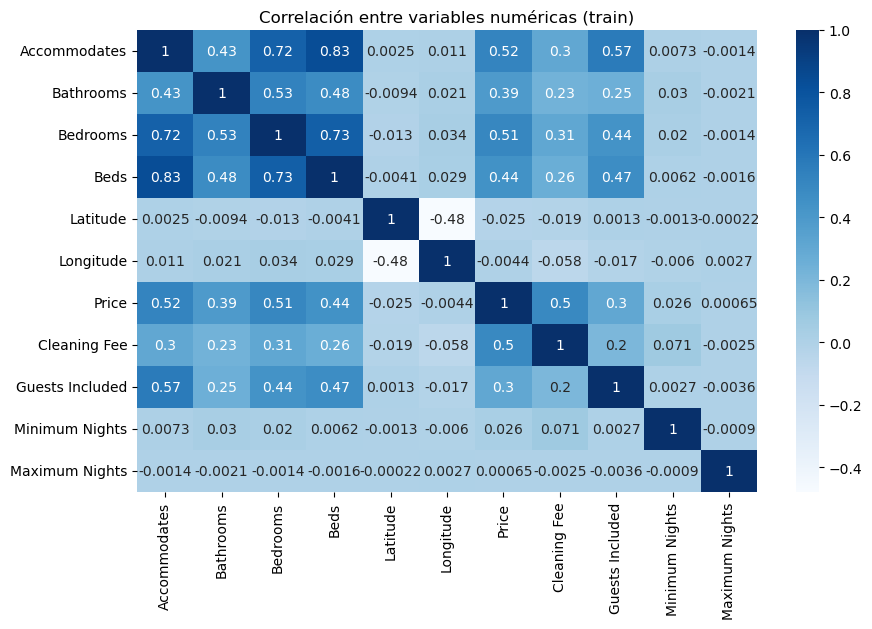

In [53]:
plt.figure(figsize=(10,6))
sns.heatmap(
    train_sel.corr(numeric_only=True),
    annot=True,
    cmap="Blues"
)
plt.title("Correlación entre variables numéricas (train)")
plt.show()


Grafico histograma


Se observa que la mayoria de las variables presentan distribuciones asimetricas con una mayor concentracion de valores bajos y una cola hacia valores altos. Esto es habitual en datos reales de precios y tamaños de alojamiento, donde existen pocos casos extremos con valores elevados.

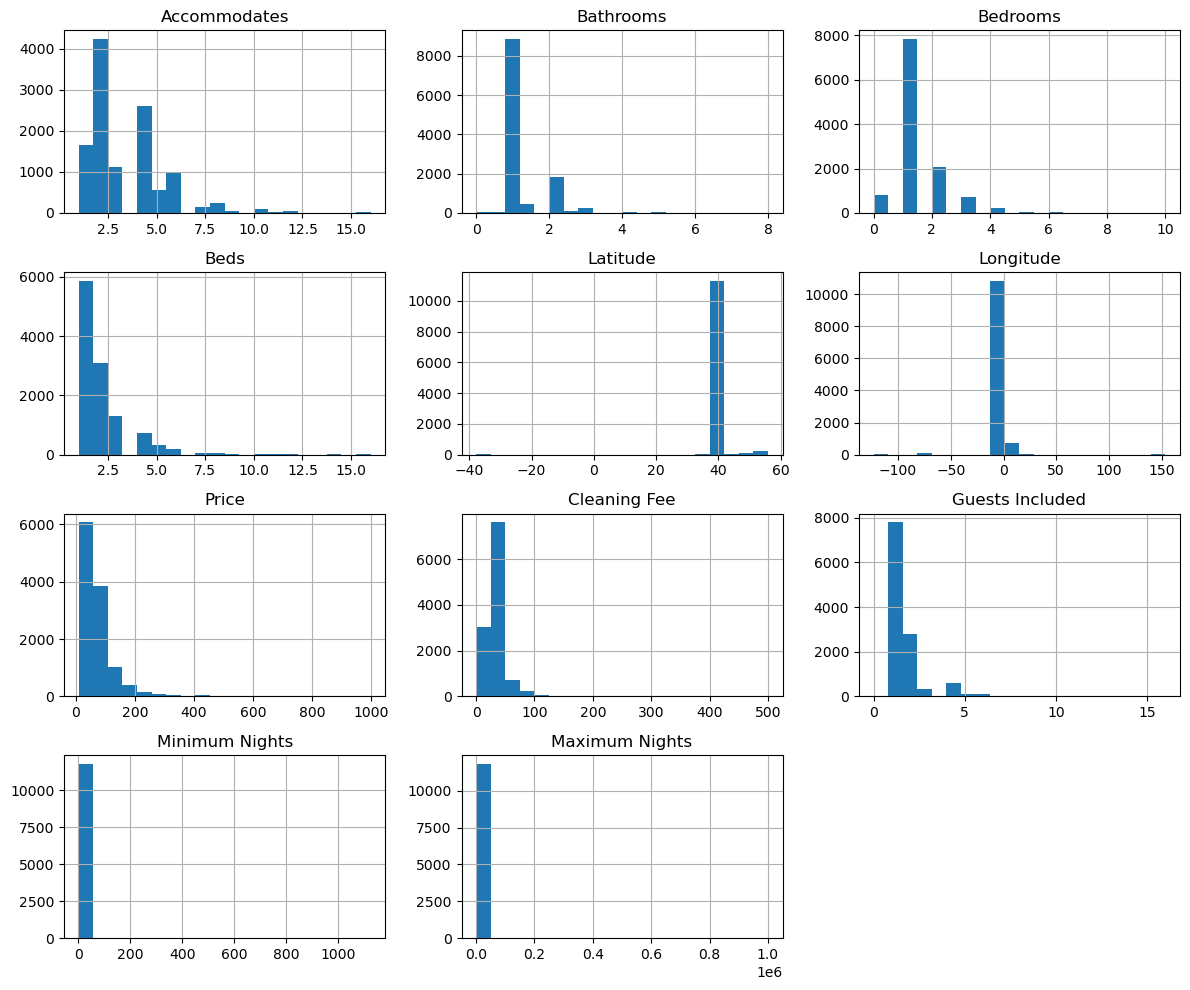

In [54]:
train_sel.hist(figsize=(12,10), bins=20)
plt.tight_layout()
plt.show()

Definición de variables predictoras y variable objetivo

Se define el precio como variable objetivo y el resto de variables seleccionadas como predictores
el preprocesamiento se integrara dentro de un pipeline para evitar fugas de información y asegurar que las transformaciones se ajustan unicamente sobre el conjunto de entrenamiento

In [55]:
y_train = train_sel["Price"]
X_train = train_sel.drop("Price", axis=1)

columnas_categoricas = ["Room Type", "Property Type"]
columnas_numericas = [c for c in X_train.columns if c not in columnas_categoricas]

preprocesamiento = ColumnTransformer(
    transformers=[
        (
            "num",
            SimpleImputer(strategy="median"),
            columnas_numericas
        ),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore"),
            columnas_categoricas
        )
    ]
)



Regresión lineal con validación cruzada

In [56]:
modelo_lr = Pipeline(steps=[
    ("prep", preprocesamiento),
    ("lr", LinearRegression())
])

rmse_lr_cv = -cross_val_score(
    modelo_lr,
    X_train,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

rmse_lr_cv.mean()


np.float64(53.65722083180128)

Random forest

In [57]:

modelo_rf = Pipeline(steps=[
    ("prep", preprocesamiento),
    ("rf", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])


In [58]:
rmse_rf_cv = -cross_val_score(
    modelo_rf,
    X_train,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

rmse_rf_cv.mean()


np.float64(47.25763292420179)

Comparacion de metodos

In [59]:
print("RMSE Regresión Lineal (CV):", rmse_lr_cv.mean())
print("RMSE Random Forest (CV):", rmse_rf_cv.mean())


RMSE Regresión Lineal (CV): 53.65722083180128
RMSE Random Forest (CV): 47.25763292420179


Conclusion:
La comparacion de modelos para predecir el precio de los alojamientos de airbnb nos dio como resultado que el metodo random forest fue el que nos da un mejor predictor que la regresion lineal, lo que indica que le precio depende de relaciones no lineales entre variables.